In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 417.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 2.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 418.6 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=250)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [8]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.20) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DO

In [9]:
display(df_buy_signal) 

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30
0,HEX-USD,0.0244684349745512,0.032401,0.02543
0,CHZ-USD,0.14241477847099304,0.185597,0.138596
0,HT-USD,5.056534767150879,6.737107,5.478311
0,FTT-USD,2.240953207015991,7.245725,3.780779
0,BTT-USD,7.413752314278099e-07,1e-06,1e-06
0,TWT-USD,1.5221413373947144,1.909251,1.455864
0,MV-USD,0.16607187688350677,0.210219,0.168801
0,XCN18679-USD,0.0116804214194417,0.037851,0.028525
0,BNX-USD,82.52643585205078,115.41183,92.520285
0,USTC-USD,0.022908730432391167,0.027578,0.022073


In [10]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=100)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [11]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[*********************100%***********************]  1 of 1 completed
LTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
LTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
LTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
LTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
LTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
LTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
WTRX-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
WTRX-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
WTRX-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
WTRX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
WTRX-USD 

IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
display(df_buy_signal)

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30
0,HEX-USD,0.0244684349745512,0.032401,0.02543
0,CHZ-USD,0.14241477847099304,0.185597,0.138596
0,HT-USD,5.056534767150879,6.737107,5.478311
0,FTT-USD,2.240953207015991,7.245725,3.780779
0,BTT-USD,7.413752314278099e-07,1e-06,1e-06
0,TWT-USD,1.5221413373947144,1.909251,1.455864
0,MV-USD,0.16607187688350677,0.210219,0.168801
0,XCN18679-USD,0.0116804214194417,0.037851,0.028525
0,BNX-USD,82.52643585205078,115.41183,92.520285
0,USTC-USD,0.022908730432391167,0.027578,0.022073


In [15]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


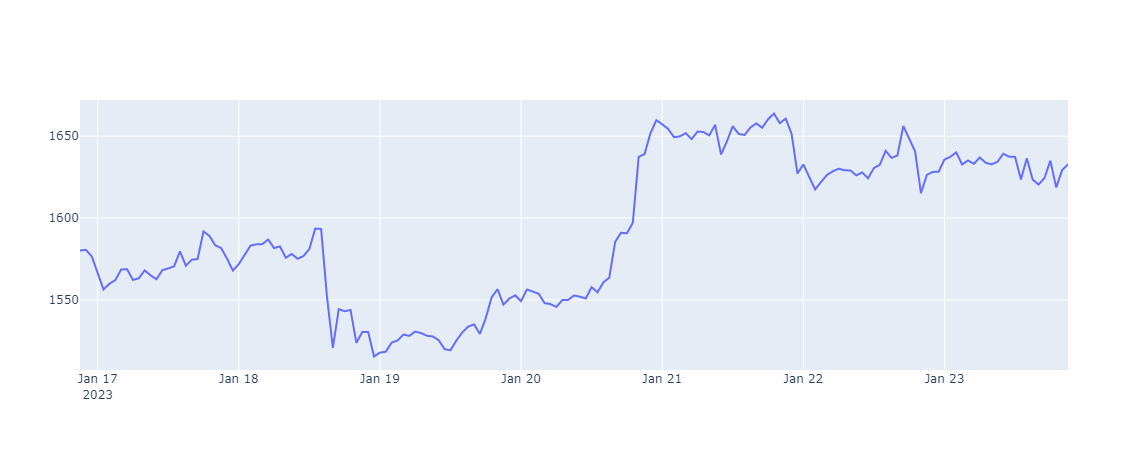

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


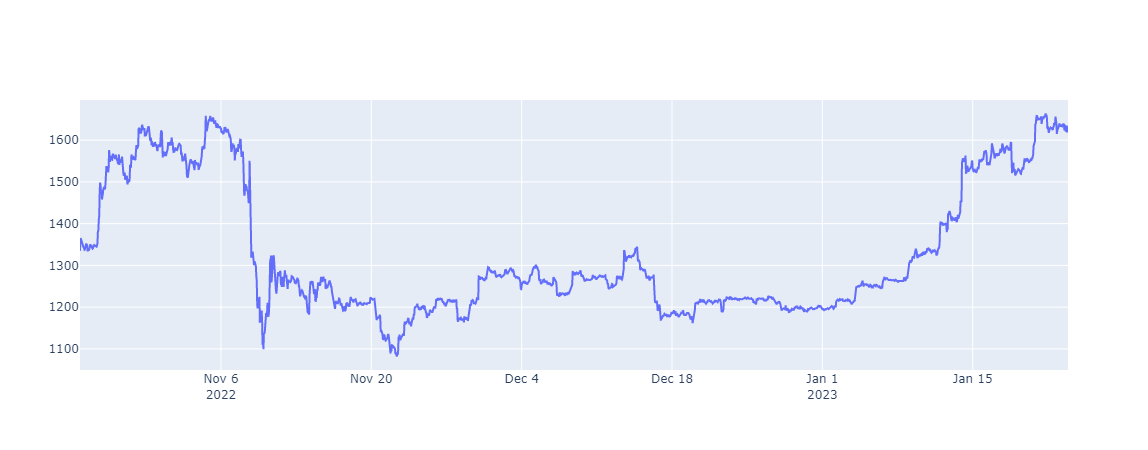

In [16]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [17]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

NameError: name 'dfx' is not defined

In [14]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-17 00:00:00+00:00,BTC-USD,21161.519531,22695.41465,17562.387806,1053.655722,588.327128,Buy
2023-01-18 00:00:00+00:00,BTC-USD,20688.78125,22214.823097,18829.803577,1079.717125,686.605127,Buy
2023-01-19 00:00:00+00:00,BTC-USD,21086.792969,21726.650784,19951.463055,1119.581358,773.200373,Buy
2023-01-20 00:00:00+00:00,BTC-USD,22676.552734,22551.014289,19917.66484,1264.873699,871.535039,Buy
2023-01-21 00:00:00+00:00,BTC-USD,22777.625,23214.470757,19768.872993,1372.35496,971.699023,Buy
2023-01-22 00:00:00+00:00,BTC-USD,22720.416016,23599.331028,19909.617633,1436.360873,1064.631393,Buy
2023-01-23 00:00:00+00:00,BTC-USD,22971.648438,23975.035836,20048.774432,1490.180503,1149.741215,Buy
2023-01-17 00:00:00+00:00,ETH-USD,1567.846069,1658.798239,1342.730919,85.060894,52.815728,Buy
2023-01-18 00:00:00+00:00,ETH-USD,1515.506958,1641.798925,1396.180009,84.532477,59.159078,Buy


,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30
0,HEX-USD,0.0244684349745512,0.032401,0.02543
0,CHZ-USD,0.14241477847099304,0.185597,0.138596
0,HT-USD,5.056534767150879,6.737107,5.478311
0,FTT-USD,2.240953207015991,7.245725,3.780779
0,BTT-USD,7.413752314278099e-07,1e-06,1e-06
0,TWT-USD,1.5221413373947144,1.909251,1.455864
0,MV-USD,0.16607187688350677,0.210219,0.168801
0,XCN18679-USD,0.0116804214194417,0.037851,0.028525
0,BNX-USD,82.52643585205078,115.41183,92.520285
0,USTC-USD,0.022908730432391167,0.027578,0.022073


In [53]:
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))

print(df_ALGO.size)

df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean()
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean()
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean()


df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values

y

df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
1313


,Close,SMA5,SMA15,SMA30
Date,,,,
2019-06-21 00:00:00+00:00,3.201412,0.000000,0.000000,0.000000
2019-06-22 00:00:00+00:00,2.158967,0.000000,0.000000,0.000000
2019-06-23 00:00:00+00:00,1.890702,0.000000,0.000000,0.000000
2019-06-24 00:00:00+00:00,1.383728,0.000000,0.000000,0.000000
2019-06-25 00:00:00+00:00,1.537290,2.034420,0.000000,0.000000
...,...,...,...,...
2023-01-19 00:00:00+00:00,0.217528,0.226249,0.211785,0.192352
2023-01-20 00:00:00+00:00,0.239776,0.226137,0.215534,0.194615
2023-01-21 00:00:00+00:00,0.239667,0.227212,0.218879,0.196878


In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

# Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 1000)



Epoch 1/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.6522 - mse: 0.6522
Epoch 2/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5414 - mse: 0.5414
Epoch 3/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.4158 - mse: 0.4158
Epoch 4/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2813 - mse: 0.2813
Epoch 5/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.1675 - mse: 0.1675
Epoch 6/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0943 - mse: 0.0943
Epoch 7/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0631 - mse: 0.0631
Epoch 8/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0530 - mse: 0.0530
Epoch 9/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0488 - mse: 0.0488
Epoch 10/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0455 - mse: 0.0455
Epoch 11/1000
24/24 [============================